# Simulaciones proyecto

En este notebook se desarrollan las simulaciones relacionadas al paper ...

Se busca probar los tests de hipótesis relacionados a la norma $L_1$ y la de $log$-Likelihood.

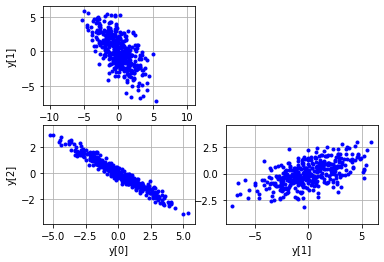

In [1]:
# generacion de datos
"""Example of generating correlated normally distributed random samples."""

import numpy as np
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid


# Choice of cholesky or eigenvector method.
method = 'cholesky'
#method = 'eigenvectors'

num_samples = 400

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# Generate samples from three independent normally distributed random
# variables (with mean 0 and std. dev. 1).
x = norm.rvs(size=(3, num_samples))

# We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
# the Cholesky decomposition, or the we can construct `c` from the
# eigenvectors and eigenvalues.

if method == 'cholesky':
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    # Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

# Convert the data to correlated random variables. 
y = np.dot(c, x)

#
# Plot various projections of the samples.
#
subplot(2,2,1)
plot(y[0], y[1], 'b.')
ylabel('y[1]')
axis('equal')
grid(True)

subplot(2,2,3)
plot(y[0], y[2], 'b.')
xlabel('y[0]')
ylabel('y[2]')
axis('equal')
grid(True)

subplot(2,2,4)
plot(y[1], y[2], 'b.')
xlabel('y[1]')
axis('equal')
grid(True)

show()

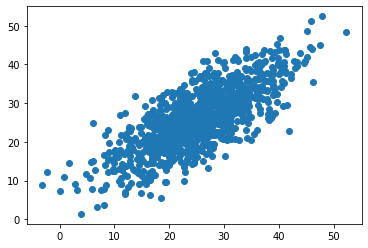

In [8]:
import numpy as np
from matplotlib.pyplot import scatter

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])


In [ ]:
# setear parametros
Dimensiones = [1, 2, 3]
# samplear n muestras de dos variables aleatorias independientes desde las sgtes distribuciones
# super-Gaussian
# sub-Gaussian
# multimodal
# unimodal
# centradas en cero y varianza unitaria

# mezclar los datos con una matriz de rotacion parametrizada por un angulo theta desde 0 a pi/4

# para las dimensiones d = {2, 3} ruido gaussiano centrado en cero y con varianza unitaria

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(100,) (100,)


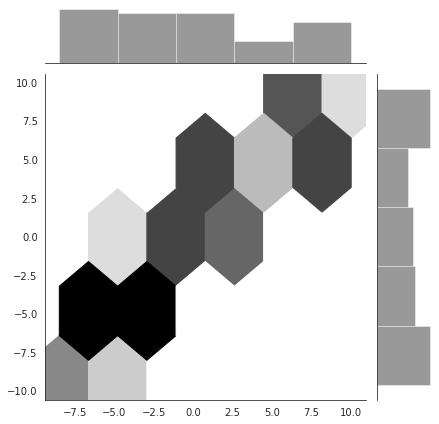

In [204]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

d = 1
n_samples = 100
X = np.array([np.random.normal(loc=-10, size=int(n_samples/4)),
              np.random.normal(loc=-3, size=int(n_samples/4)),
              np.random.normal(loc=3, size=int(n_samples/4)),
              np.random.normal(loc=10, size=int(n_samples/4))]).reshape((n_samples,))

# Y = np.array([np.random.normal(size=5000), np.random.normal(size=5000)]).reshape((n_samples,))
# X = np.array([np.random.normal(size=5000), np.random.normal(size=5000)]).reshape((n_samples,))
Y = np.array([np.random.normal(size=int(n_samples/2)), np.random.normal(size=int(n_samples/2))]).reshape((n_samples,))
# Y = np.zeros((n_samples,))

theta = (np.pi / 4) * 1

rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])

print(rotationMatrix)
print(X.shape, Y.shape)

[X, Y] = rotationMatrix @ [X, Y]

with sns.axes_style("white"):
    sns.jointplot(x=X, y=Y, kind="hex", color="k");

## Estadístico basado en norma $L_1$

Primero se calcula el test basado en la norma $L_1$. Donde su formulación es:

$$
    L_1(\nu_n, \ \mu_{n,1} \times \mu_{n,2}) =
    \sum_{A\in P_n}\sum_{B\in Q_n} |\nu_n(A\times B) - \mu_{n,1}(A) \cdot \mu_{n,2}(B)|
$$
    
Donde se tiene que dicho estadístico sobrepasa un umbral dado por el test de hipótesis, que está dado por

$$
    L_{n}(\nu_{n}, \mu_{n,1}\times\mu_{n,2})>  c_{1}\left(\sqrt{\frac{m_{n} \cdot m'_{n}}{n}} + \sqrt{\frac{m_{n}}{n}} + \sqrt{\frac{m'_{n}}{n}}\right)  \approx c_{1}\sqrt{\frac{m_{n} \cdot m'_{n}}{n}}
$$

In [205]:
plotear = False

# particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
mX = 4
mY = 4
minx = np.min(X)
maxx = np.max(X)
dx = maxx - minx

miny = np.min(Y)
maxy = np.max(Y)
dy = maxy - miny

totalXY = X.shape[0]
totalX = X.shape[0]
totalY = Y.shape[0]

L1 = 0

# el umbral
umbral = 1.177 * np.sqrt(mX * mY / n_samples)

for mx in range(mX):
    ax, bx = [minx + dx * mx / mX,
              minx + dx * (mx + 1) / mX] # se define intervalo de la particion
    for my in range(mY):
        ay, by = [miny + dy * my / mY,
                  miny + dy * (my + 1) / mY] # se define intervalo de la particion
        
        intervaloX = np.array([X < bx]) * np.array([X > ax])
        intervaloY = np.array([Y < by]) * np.array([Y > ay])
        c = np.sum(intervaloX[0] * intervaloY[0])
        
        nuN = c / n_samples
        muNX = np.sum(intervaloX) / n_samples
        muNB = np.sum(intervaloY) / n_samples
        
        aux = np.abs(nuN - muNX * muNB)
        L1 += aux
        
        if plotear:
            plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                        y=Y[intervaloX[0] * intervaloY[0]],
                        cmap="PuOr", alpha=0.1)
            plt.vlines(bx, ymin=miny, ymax=maxy)
            plt.hlines(by, xmin=minx, xmax=maxx)
            plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))

print('L1 : {:.4f} umbral {:.4f}'.format(L1, umbral))

if L1 < umbral: print('son independientes')
else: print('son dependientes')
print(mX / np.log(n_samples))
print(mX * mY / n_samples)


L1 : 1.3212 umbral 0.4708
son dependientes
0.8685889638065035
0.16


## Estadístico basado en $log$-verosimilitud

La forma de este estadístico es:

$$
I_n(\nu_n,\mu_{n,1}\times\mu_{n,2}) = \sum_{A\in P_n}\sum_{B\in Q_n}\nu_n(A\times B)\log{\frac{\nu_n(A\times B)}{\mu_{n,1}(A)\cdot\mu_{n,2}(B)}}
$$

donde el umbral está definido por

$$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{m_nm'_n(\log{(n + m_nm'_n) + 1})}{n}
$$

<!-- $$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{\Phi^{-1} (1-\alpha) \sqrt{2m_{n} m'_{n}} + m_{n}m'_{n}}{2n}
$$
 -->

I1 : 1.1567 umbral 0.9206
son dependientes
Condicion : 0.7606


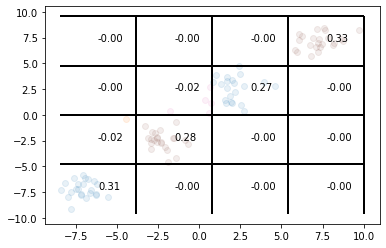

In [216]:
plotear = True

# particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
mX = 4
mY = 4
minx = np.min(X)
maxx = np.max(X)
dx = maxx - minx

miny = np.min(Y)
maxy = np.max(Y)
dy = maxy - miny

totalXY = X.shape[0]
totalX = X.shape[0]
totalY = Y.shape[0]

I1 = 0

# el umbral
umbral = mX * mY * (np.log(n_samples + mX * mY) + 1) / n_samples
eps = 1e-4

for mx in range(mX):
    ax, bx = [minx + dx * mx / mX,
              minx + dx * (mx + 1) / mX] # se define intervalo de la particion
    for my in range(mY):
        ay, by = [miny + dy * my / mY,
                  miny + dy * (my + 1) / mY] # se define intervalo de la particion
        
        intervaloX = np.array([X < bx]) * np.array([X > ax])
        intervaloY = np.array([Y < by]) * np.array([Y > ay])
        c = np.sum(intervaloX[0] * intervaloY[0])
        
        nuN = c / n_samples
        muNX = np.sum(intervaloX) / n_samples
        muNB = np.sum(intervaloY) / n_samples
        
        aux = nuN * np.log(nuN / (muNX * muNB) + eps)
        I1 += aux
        
        if plotear:
            plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                        y=Y[intervaloX[0] * intervaloY[0]],
                        cmap="PuOr", alpha=0.1)
            plt.vlines(bx, ymin=miny, ymax=maxy)
            plt.hlines(by, xmin=minx, xmax=maxx)
            plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))

print('I1 : {:.4f} umbral {:.4f}'.format(I1, umbral))

if I1 < umbral: print('son independientes')
else: print('son dependientes')

print('Condicion : {:.4f}'.format(mX * mY / n_samples * np.log(n_samples + mX * mY)))